![](cg.png)

# Forecasting Sales Data 
- Author: Julian Ibarra
- Description: Data Analysis, Data Exploration, Visualization, and Forecasting on Capital Group's sales data

# Table of Contents
- Introduction
    - Data Overview
- Basic Preparation
    - Import Libraries
    - Load Data
- Exploratory Data Analysis
    - Data Manipulation
    - Data Imputation
    - Visualizations
- Do visits drive sales?
    - Scatterplot to check for correlation
    - Correlation coefficient
        - Correlation coefficient interpretation
- Forecast Sales using ARIMA Modeling
    - Stationary Data
    - Augmented Dickey Fuller Test
        - Interpreting ADF Test
    - ACF and PACF Plots
        - Interpreting Plots
    - Auto ARIMA
    - Building ARIMA Model
    - Forecast Future Visits
- Insights and Recommendations
- Conclusion



#### This assignment will attempt to answer the following questions:
- Do visits drive sales?
- If yes, can we forecast the average number of visits month over month for the years 2021 and 2022? 

- The metrics that are being used to choose the best model are RMSE and MAPE. 

## Data Overview
- The data collected is from 2018 through 2020 and is separated into two separate sheets: one for Wealth Management Sales and Global Opportunity data and another for Wholesalers (WLSR) visit records.
- The opportunity_data consists of 8269 observations and the visits_data consists of 14211 observations. 
- Assumptions: features that are not relevant to the goal will be removed. 


# Basic Preparation

### Import Libraries

In [38]:
# Import necessary libraries
import os

# Data processing
from pandas import read_excel
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Data visualization
import matplotlib.pyplot as plt
import matplotlib.style as style 
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Load Data

In [39]:
# Set working directory
os.chdir("/Users/JIbarra/Downloads")

# Import the dataset 
my_sheet = 'opportunity_data'
my_sheet2 = 'visits_data'
file_name = 'Dataset - BI roles - v5.xlsx'

opportunity = read_excel(file_name, sheet_name = my_sheet)
visits = read_excel(file_name, sheet_name = my_sheet2)

# Print data dimensions
print("opportunity dimensions: {}".format(opportunity.shape))
print("visits dimensions: {}".format(visits.shape))

opportunity dimensions: (8269, 12)
visits dimensions: (14210, 9)


## Exploratory Data Analysis

### Data Manipulation

In [40]:
print("opportunity dimensions: {}".format(opportunity.shape))
opportunity.head()

opportunity dimensions: (8269, 12)


,CGFirmUID,FirmName,Year,WholesalerTerritoryName,WholesalerTerritoryUID,MorningstarAssetClass,AFSaleWM,AFSaleAdvisory,AFSaleBrokerage,GlobalSaleWM,GlobalSaleAdvisory,GlobalSaleBrokerage
0,3352,West Coast Mutual,2019,XC Minneapolis,174,Allocation,30.48,0.00,30.48,632.94,0.00,632.94
1,2074,Lone Wolf Financial,2019,XC Tennessee,189,International Equity,2.78,0.00,2.78,1055.63,996.23,59.40
2,2074,Lone Wolf Financial,2018,XC PAC NW/AK,138,International Equity,0.00,0.00,0.00,835.29,825.60,9.68
3,2074,Lone Wolf Financial,2020,XC Long Island,105,Municipal Bond,22.07,22.07,0.00,3854.39,3061.23,793.16
4,3352,West Coast Mutual,2019,XC MO/Eastern KS,157,International Equity,151.11,85.41,65.70,1123.41,559.37,564.05


In [41]:
print("visits dimensions: {}".format(visits.shape))
visits.head()

visits dimensions: (14210, 9)


,parent_org,visit_id,start_date_time__c,terr_nm_at_visit,terr_uid_at_visit,virtual__c,count_total_attendees_on_visit,meeting_type,status__c
0,Karin Larson Financial LLC,a0H0y00000me4BjEAI,2020-06-08 19:00:00,XC Milwaukee,195,Yes,16512,LRG-GRP,Done
1,West Coast Mutual LLC,a0H0y00000hcCYrEAM,2020-09-23 14:00:00,XC Nebraska,153,Yes,13734,LRG-GRP,Done
2,Jonathan Lovelace Firm,a0H0y00000hcD3nEAE,2020-09-16 14:00:00,XC Wisconsin,181,Yes,9975,LRG-GRP,Done
3,Jonathan Lovelace Firm,a0H0y00000hcNNHEA2,2020-07-22 14:00:00,XC S MN/NW/WI,1302,Yes,7126,LRG-GRP,Done
4,Karin Larson Financial LLC,a0H0y00000hcBq9EAE,2020-08-12 14:00:00,XC Iowa,183,Yes,6622,LRG-GRP,Done


In [42]:
def opportunity_prep(data):
    opportunity_data = data.copy()
    opportunity_data.drop(columns=['CGFirmUID', 'WholesalerTerritoryUID', 'MorningstarAssetClass',
                  'AFSaleAdvisory', 'AFSaleBrokerage', 'GlobalSaleAdvisory', 'GlobalSaleBrokerage'], inplace=True)
    opportunity_data = opportunity_data.groupby(["Year", "WholesalerTerritoryName", "FirmName"])[["AFSaleWM"]].sum().reset_index()
    return opportunity_data

opportunity_df = opportunity_prep(opportunity)
print("opportunity dimensions: {}".format(opportunity_df.shape))
opportunity_df.head()

opportunity dimensions: (1120, 4)


,Year,WholesalerTerritoryName,FirmName,AFSaleWM
0,2018,FC ATL,James Rothenberg Wealth Management,32802.14
1,2018,FC ATL,Marjorie Fisher Investments,15858.11
2,2018,FC ATL,SMD Group,0.00
3,2018,FC CEN FL,Aoki Investments,0.00
4,2018,FC CEN FL,Marjorie Fisher Investments,1538.70


In [43]:
def visits_prep(data):
    visits_data = data.copy()
    visits_data['Year'] = visits_data['start_date_time__c'].dt.year
    visits_data.rename(columns={'parent_org': 'FirmName', 'terr_nm_at_visit': 'WholesalerTerritoryName'}, inplace=True)
    visits_data.drop(columns=["virtual__c", "visit_id", "terr_uid_at_visit", "count_total_attendees_on_visit"], inplace=True)
    visits_data2 = visits_data.groupby(["Year", "WholesalerTerritoryName", "FirmName"]).agg(visit_count = ('status__c','count'),).reset_index()
    return visits_data2

visits_df = visits_prep(visits)
print("visits dimensions: {}".format(visits_df.shape))
visits_df.head()

visits dimensions: (1391, 4)


,Year,WholesalerTerritoryName,FirmName,visit_count
0,2018,FC ATL,Aoki Investments,9
1,2018,FC ATL,James Rothenberg Wealth Management,60
2,2018,FC ATL,Marjorie Fisher Financial Services Inc.,19
3,2018,FC Boston,Aoki Investments,26
4,2018,FC Boston,James Rothenberg Wealth Management,52


### Data Imputation

In [44]:
# Determine if there are any null/empty values in the datasets
df_list = [opportunity, visits]
df_list_names = ["opportunity", "visits"]

for i, n in zip(df_list, df_list_names):
    null_status = i.isnull().values.any()
    if null_status:
        print(n + " has null values")
    else:
        print(n + " doesn't have null values")

opportunity doesn't have null values
visits has null values


In [45]:
# Compute summary of statistics
opportunity.loc[:,"AFSaleWM":"GlobalSaleBrokerage"].describe()

,AFSaleWM,AFSaleAdvisory,AFSaleBrokerage,GlobalSaleWM,GlobalSaleAdvisory,GlobalSaleBrokerage
count,8269.000000,8269.000000,8269.000000,8.269000e+03,8.269000e+03,8269.000000
mean,536.685418,260.625429,276.060016,1.791382e+04,1.397213e+04,3901.413264
std,1265.502048,727.524239,763.604561,4.123637e+04,3.670216e+04,9053.483525
min,-8.940000,-8.940000,-5.780000,-2.077000e+01,-4.501000e+01,-399.680000
25%,0.000000,0.000000,0.000000,2.686300e+02,1.186000e+02,3.090000
50%,0.130000,0.000000,0.000000,3.926170e+03,2.475430e+03,389.720000
75%,418.540000,163.750000,123.120000,1.998266e+04,1.389774e+04,3146.680000
max,19008.070000,17604.740000,13057.410000,1.355862e+06,1.222442e+06,147995.260000


In [46]:
# Max, Min, and Average sales by year
list = ["AFSaleWM", "AFSaleAdvisory","AFSaleBrokerage","GlobalSaleWM","GlobalSaleAdvisory","GlobalSaleBrokerage"]
opportunity.groupby(["Year"],as_index=False)[list].agg(['mean', 'max', 'min'])

AFSaleWM                 AFSaleAdvisory                  \
            mean       max   min           mean       max   min   
Year                                                              
2018  487.687936  15526.17 -8.94     239.135005   8005.54 -8.94   
2019  506.477800  16171.00 -6.87     222.108790  16136.29 -1.09   
2020  616.386855  19008.07  0.00     321.071184  17604.74  0.00   

     AFSaleBrokerage                  GlobalSaleWM                     \
                mean       max   min          mean         max    min   
Year                                                                    
2018      248.552985  13057.41  0.00  15495.259061  1039416.40   0.00   
2019      284.369003   8365.83 -5.78  16489.083443  1012097.22 -20.77   
2020      295.315703   6430.78  0.00  21781.040488  1355862.26   0.00   

     GlobalSaleAdvisory                    GlobalSaleBrokerage             \
                   mean         max    min                mean        max   
Year                                                                        
2018       12240.207661   985747.32   0.00         3209.635644   75501.87   
2019       12415.671228   864101.97 -45.01         4045.747840  147995.26   
2020       17282.316778  1222441.87   0.00         4450.871279  133420.39   

              
         min  
Year          
2018 -399.68  
2019    0.00  
2020  -44.31

In [47]:
# Max, Min, and Average visits by year
visits.groupby(visits["start_date_time__c"].dt.year)['count_total_attendees_on_visit'].agg(['sum', 'mean', 'max', 'min', 'std'])


,sum,mean,max,min,std
start_date_time__c,,,,,
2018,139196,30.076923,1932,1,79.840627
2019,105134,22.830402,1538,1,61.109750
2020,330718,66.449267,16512,1,471.841640


### Visualizations

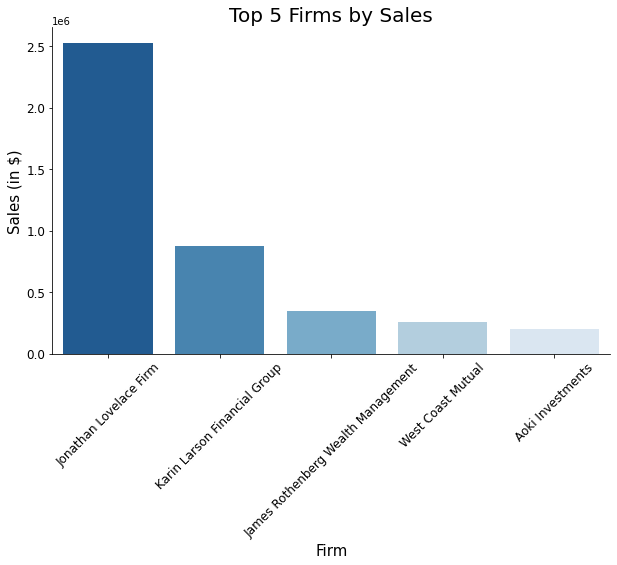

In [48]:
def sales_per_firm():
    by_firm = opportunity.groupby('FirmName')['AFSaleWM'].sum().reset_index()
    
    fig, ax = plt.subplots(figsize=(10,6))
    sns.barplot(data = by_firm.nlargest(5, 'AFSaleWM'), 
                x = 'FirmName', y = 'AFSaleWM', palette="Blues_r")
        
    ax.set_title("Top 5 Firms by Sales", fontsize = 20)
    ax.set_xlabel("Firm", fontsize = 15)
    ax.set_ylabel("Sales (in $)", fontsize = 15)
    
    ax.tick_params(axis='x', labelsize=12, rotation=45)
    ax.tick_params(axis='y', labelsize=12)

    sns.despine()
    
sales_per_firm()

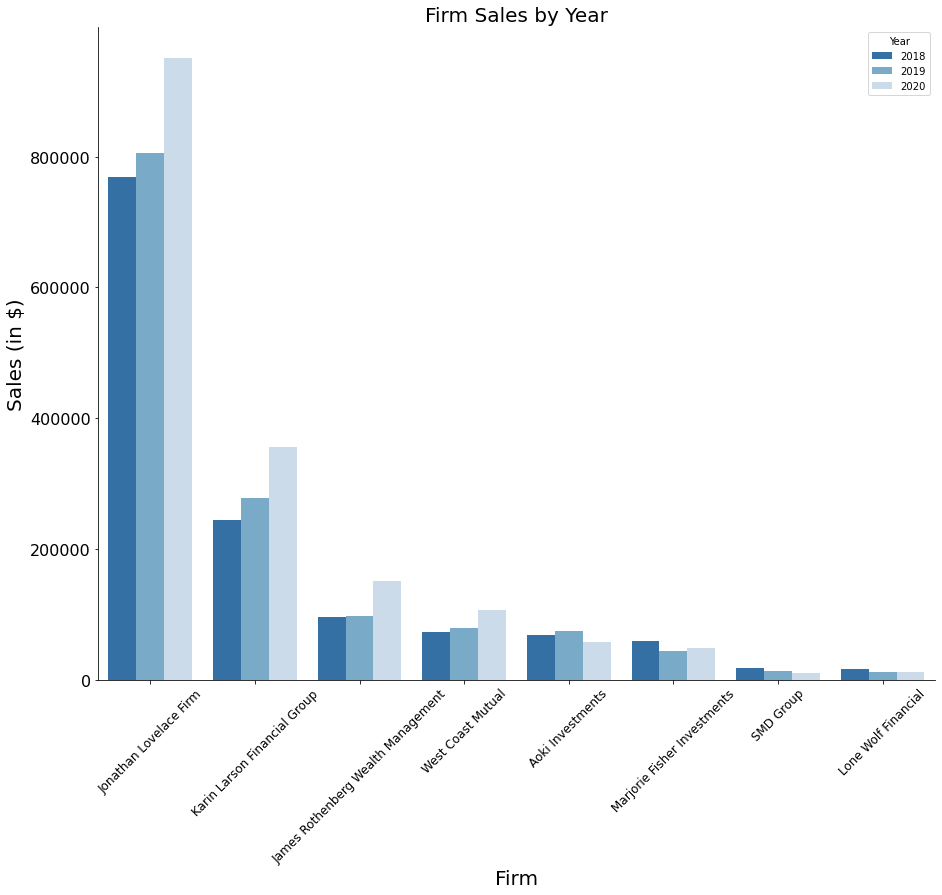

In [49]:
def sales_per_firm_year():
    by_firm = opportunity.groupby(['FirmName', 'Year'])['AFSaleWM'].sum().reset_index()
    by_firm.sort_values('AFSaleWM', inplace=True, ascending=False)
    
    fig, ax = plt.subplots(figsize=(15,12))
    sns.barplot(data = by_firm, 
                x = 'FirmName', y = 'AFSaleWM',
                hue = "Year", palette="Blues_r")
    
    ax.set_title("Firm Sales by Year", fontsize = 20)
    ax.set_xlabel("Firm", fontsize = 20)
    ax.set_ylabel("Sales (in $)", fontsize = 20)
    
    ax.tick_params(axis='x', labelsize=12, rotation=45)
    ax.tick_params(axis='y', labelsize=16)

    sns.despine()
    
sales_per_firm_year()

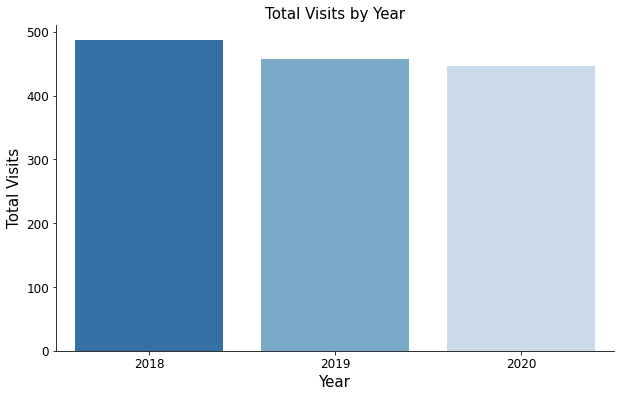

In [50]:
def visit_count():
    visit_cnt = visits_df.groupby(['Year'])['visit_count'].count().reset_index()

    fig, ax = plt.subplots(figsize=(10,6))
    bars = sns.barplot(data = visit_cnt, 
                x = 'Year', y = 'visit_count', palette="Blues_r")
    
    ax.set_title("Total Visits by Year", fontsize = 15)
    ax.set_xlabel("Year", fontsize = 15)
    ax.set_ylabel("Total Visits", fontsize = 15)
    
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

    sns.despine()
    
visit_count()

In [51]:
visits_df

,Year,WholesalerTerritoryName,FirmName,visit_count
0,2018,FC ATL,Aoki Investments,9
1,2018,FC ATL,James Rothenberg Wealth Management,60
2,2018,FC ATL,Marjorie Fisher Financial Services Inc.,19
3,2018,FC Boston,Aoki Investments,26
4,2018,FC Boston,James Rothenberg Wealth Management,52
...,...,...,...,...
1386,2020,XC Wisconsin,James Rothenberg Wealth Management,6
1387,2020,XC Wisconsin,Jonathan Lovelace Firm,55
1388,2020,XC Wisconsin,Karin Larson Financial LLC,16
1389,2020,XC Wisconsin,SMD Markets LLC,5


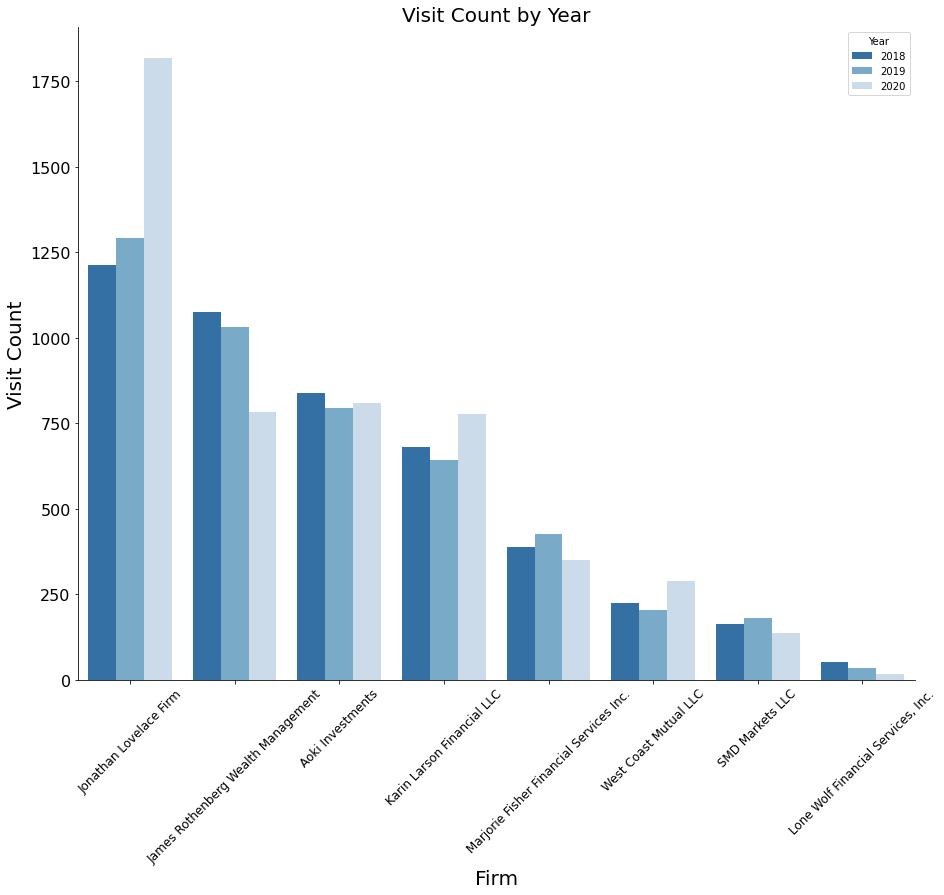

In [52]:
def count_per_firm_year():
    by_firm = visits_df.groupby(['FirmName', 'Year'])['visit_count'].sum().reset_index()
    by_firm.sort_values('visit_count', inplace=True, ascending=False)
    
    fig, ax = plt.subplots(figsize=(15,12))
    sns.barplot(data = by_firm, 
                x = 'FirmName', y = 'visit_count',
                hue = "Year", palette="Blues_r")
    
    ax.set_title("Visit Count by Year", fontsize = 20)
    ax.set_xlabel("Firm", fontsize = 20)
    ax.set_ylabel("Visit Count", fontsize = 20)
    
    ax.tick_params(axis='x', labelsize=12, rotation=45)
    ax.tick_params(axis='y', labelsize=16)

    sns.despine()
    
count_per_firm_year()

## Do visits drive sales?

In order to determine whether or not visits drive sales, I'm going to be using a correlation test evaluate the association between the sales variable and count of visits by Year, Territory Name, and Firm Name. 

In [53]:
# Merge the visits dataframe and opportunity dataframe by Year, Territory Name, and Firm Name.
def visit_opp_data():
    return visits_df.merge(opportunity_df, on=["FirmName", "WholesalerTerritoryName", "Year"])

merge_data = visit_opp_data()

In [54]:
merge_data.head()

,Year,WholesalerTerritoryName,FirmName,visit_count,AFSaleWM
0,2018,FC ATL,James Rothenberg Wealth Management,60,32802.14
1,2018,FC CEN FL,Aoki Investments,11,0.00
2,2018,FC DFW-SA-ATX,Aoki Investments,10,10097.33
3,2018,FC DFW-SA-ATX,James Rothenberg Wealth Management,10,10175.76
4,2018,FC Detroit,Aoki Investments,48,0.00


### Using a scatterplot to check for correlation
In the plot below, you can quickly see that as the number of visits increase the amount of sales increases; however, we want to reinforce this visual with a statistical test, this our case Spearman's correlation. 

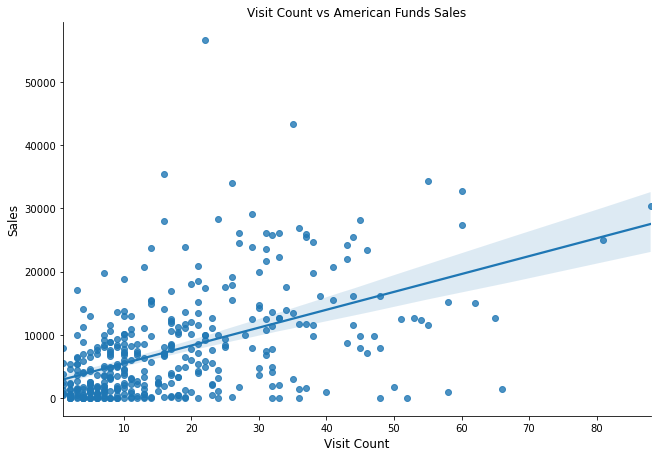

In [55]:
# Plot the linear regression scatterplot
def lm_boxplot():
    sns.lmplot(
        data = merge_data, 
        x ='visit_count', y ='AFSaleWM', 
        palette="Blues_r", height=6, aspect = 1.5)

    ax = plt.gca()
    ax.set_title("Visit Count vs American Funds Sales")
    ax.set_xlabel("Visit Count", fontsize = 12)
    ax.set_ylabel("Sales", fontsize = 12)

lm_boxplot()

### Understanding sales and visits relationship using a correlation coefficient
Correlation coefficients measure the strength of the relationship between two variables. A correlation between variables indicates that as one variable changes in value, the other variable tends to change in a specific direction.

correlation coefficients are a quantitative assessment that measures both the direction and the strength of this tendency to vary together.

Our goal is to better understand the relationship between sales and visits. We decided on Spearman's correlation because we are dealing with a continuous variable (Sales) and a discrete variable (Count of Visits). 

In [56]:
# Display the correlation 
def get_corrs(df):
    # Merge the datasets based on the 3 columns: "FirmName", "WholesalerTerritoryName", and "Year"
    #merge_df = visits_df.merge(opportunity_df, on=["FirmName", "WholesalerTerritoryName", "Year"])
    
    # Calculate the correlation coefficient
    col_correlations = df.corr(method="spearman")
    col_correlations.loc[:, :] = np.tril(col_correlations, k=-1)
    cor_pairs = col_correlations.stack()
    return cor_pairs.to_dict()

my_corrs = get_corrs(merge_data)

# Print the following line to retrieve a single correlation
print("Sales and visits have a correlation magnitude of" ,my_corrs[('AFSaleWM','visit_count')])

Sales and visits have a correlation magnitude of 0.5098707826476464


#### Interpreting the correlation coefficient:
The greater the value of the coefficient, the stronger the relationship. The sign of the coefficient determines the direction of the relationship; so, (+) means a positive correlation and (-) means a negative correlation. 

    The following can be used as a rule of thumb:
    - .90 to 1.00 Very high correlation
    - .70 to .90 High correlation
    - .50 to .70 Moderate correlation
    - .30 to .50 Low Correlation
    - .00 to .30 Negligable Correlation
    
We ended up with a correlation coefficient of 0.51. Now, while 0.51 isn't immensly high, it's enough to say that visits do have some sort of positive effect on sales. In other words, as the number of visits increases the number of sales increases. 

             visit_count  AFSaleWM
visit_count     1.000000  0.509871
AFSaleWM        0.509871  1.000000


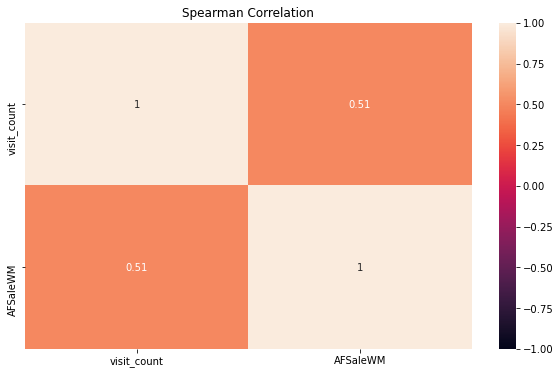

In [57]:
# Display the correlation in a heatmap
def display_correlation(df, column):
    df.drop([column], axis=1, inplace=True)
    r = df.corr(method="spearman")
    plt.figure(figsize=(10,6))
    heatmap = sns.heatmap(df.corr(), vmin=-1, 
                      vmax=1, annot=True)
    plt.title("Spearman Correlation")
    return(r)

my_plot = display_correlation(merge_data, 'Year')

# Print the following line to retrieve a single plot
print(my_plot)

We've created a heatmap to show an alternate way of displaying correlation. The results are redundant but the visual is easy to interpret. 

Now, because we were able to determine that the number of visits does drive sales, we have decided to forecast sales using time series modeling, in this case ARIMA or autoregressive integrated moving average.

# Forecast Sales using ARIMA Modeling 
An autoregressive integrated moving average, or ARIMA, is a statistical analysis model that uses time series data to either better understand the data set or to predict future trends. A statistical model is autoregressive if it predicts future values based on past values.

ARIMA Parameters: <br>
<br>
Each component in ARIMA functions as a parameter with a standard notation. For ARIMA models, a standard notation would be ARIMA with p, d, and q, where integer values substitute for the parameters to indicate the type of ARIMA model used. The parameters can be defined as:

 - p: the number of lag observations in the model; also known as the lag order.
 - d: the number of times that the raw observations are differenced; also known as the degree of differencing.
 - q: the size of the moving average window; also known as the order of the moving average.<br>

In an autoregressive integrated moving average model, the data are differenced in order to make it stationary. A model that shows stationarity is one that shows there is constancy to the data over time.

In [58]:
# Prep the data and perform transformations prior to modeling
def monthly_visits(data):
    monthly_data = data.copy()
    monthly_data.start_date_time__c = pd.to_datetime(monthly_data['start_date_time__c']).dt.date
    monthly_data.start_date_time__c = pd.to_datetime(monthly_data['start_date_time__c'], infer_datetime_format=True)
    monthly_data.start_date_time__c =  pd.to_datetime(monthly_data['start_date_time__c'], format='%Y-%m-%d')
    monthly_data = monthly_data.groupby('start_date_time__c')['status__c'].count().reset_index()
    return monthly_data

monthly_df = monthly_visits(visits)
# Index the dataset
monthly_df_index = monthly_df.set_index(['start_date_time__c'])
monthly_df_index.head(5)

,status__c
start_date_time__c,
2018-01-03,2
2018-01-04,3
2018-01-05,5
2018-01-15,1
2018-01-16,25


### Determine if the data is stationary


The next step is determining whether or not the dat is stationary. Stationary means that it’s statistical properties are constant with time.

Stationary data will typicall consist of the following: 
1. Constant Mean
2. Constant Variance
3. No Seasonality

First thing is to check for stationarity, and if it is not stationary the data will need to be converted. The check can be done using a test called the Augmented Dickey Fuller Test. 

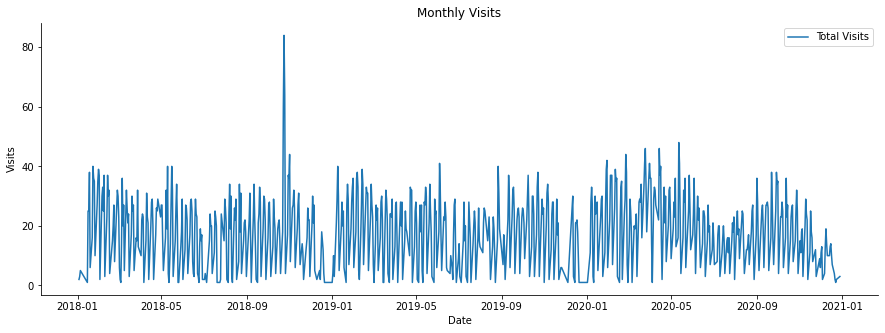

In [59]:
# Plot a time plot to inspect the data's mean and variance
def time_plot(data, x_col, y_col, title):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(x_col, y_col, data=data, ax=ax, label='Total Visits', palette='Blues_r')
    
    second = data.groupby(data.start_date_time__c.dt.year)[y_col].mean().reset_index()
    second.start_date_time__c = pd.to_datetime(second.start_date_time__c, format='%Y')
    
    ax.set(xlabel = "Date",
           ylabel = "Visits",
           title = title)
    
    sns.despine()
    
time_plot(monthly_df, 'start_date_time__c', 'status__c', 'Monthly Visits')

It's easy to tell based off of the time plot that the data has a constant mean around 20 and the fluxuations are the same. However, the code below will give us furuther indications on whether or not the data is stational. 

### Augmented Dickey Fuller Test

In [60]:
from statsmodels.tsa.stattools import adfuller

# Perform an Augmented Dickey Fuller Test
def ad_test(dataset):
    
    dftest = adfuller(dataset, autolag = 'AIC')
    
    print("The ADF is", dftest[0])
    print("The p-value is", dftest[1])
    print("The number of lags are", dftest[2])
    print("The number of observations used for ADF regression are",dftest[3])
    print("Critical Values :")
    for key, val in dftest[4].items():
         print("\t",key, ": ", val)
               
ad_test(monthly_df['status__c'])
    

The ADF is -5.122094517087266
The p-value is 1.2653579480458825e-05
The number of lags are 10
The number of observations used for ADF regression are 739
Critical Values :
	 1% :  -3.439229783394421
	 5% :  -2.86545894814762
	 10% :  -2.5688568756191392


#### Interpreting the ADF statistical test:

In order to interpret the ADF test, we need to look at the p-value. If p<0.05, than the data is considered stationary and if the p>0.05 than the data is not stationary.

The results show that we have a p-value of 0.000126, which is well below 0.05. This means that the dat requires no transformations. 

### Is the data stationary?

After running all our tests, we can conclude that the data is indeed stationary. Because of this we can assign the d value or (I) in our ARIMA model with 0. 

### ACF and PACF Plots

Autocorrelation function (ACF), and Partial autocorrelation function (PACF) plots of the series are necessary to determine the order of AR and/ or MA terms. Though ACF and PACF do not directly dictate the order of the ARMA model, the plots can facilitate understanding the order and provide an idea of which model can be a good fit for the time-series data.

   - ACF plot is a bar chart of coefficients of correlation between a time series and it lagged    values. In the ACF plot, the x-axis expresses the correlation coefficient whereas the y-axis mentions the number of lags.
   - PACF is the partial autocorrelation function that explains the partial correlation between the series and lags of itself.
   
I used the ACF and PACF plots to cross the compare the optimal order models with the "auto_arima" function that I used below. 

<Figure size 1080x576 with 0 Axes>

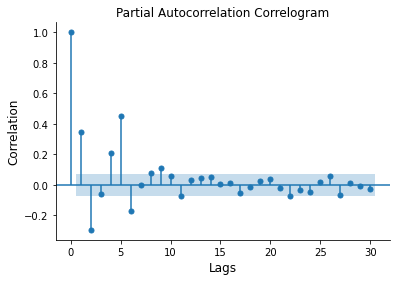

In [61]:
def partial_autocorrelation_coeff(data):
    
    dt_data = data.set_index('start_date_time__c')
    plt.figure(figsize=(15,8))
    dt_data.dropna(axis=0)
    
    sm.graphics.tsa.plot_pacf(dt_data, lags=30)

    ax = plt.gca()
    ax.set_title("Partial Autocorrelation Correlogram")
    ax.set_xlabel("Lags", fontsize = 12)
    ax.set_ylabel("Correlation", fontsize = 12)

    sns.despine()
    
partial_autocorrelation_coeff(monthly_df)

<Figure size 1080x576 with 0 Axes>

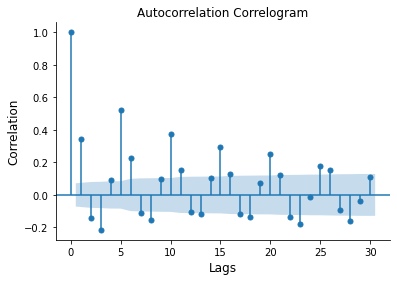

In [62]:
def autocorrelation_coeff(data):
    
    dt_data = data.set_index('start_date_time__c')
    plt.figure(figsize=(15,8))
    dt_data.dropna(axis=0)
    
    sm.graphics.tsa.plot_acf(dt_data, lags=30)

    ax = plt.gca()
    ax.set_title("Autocorrelation Correlogram")
    ax.set_xlabel("Lags", fontsize = 12)
    ax.set_ylabel("Correlation", fontsize = 12)

    sns.despine()
    
autocorrelation_coeff(monthly_df)

#### Interpreting the ACF and PACF plots and creating the ARIMA order:

First of all, because our data is stationary and was differenced 0 times, we can label our d value as 0. This it is I(0)

When interpreting ACF and PACF plots, we can ignore the first lag (0). With ARMA, the orders of p and q for AR and MA can be more than one. So testing out a few p and q combinations is advised to get the better score of AIC and BIC. That is what is happening in our plots. 

To get the p value for AR for ARMA model, we will look at PACF plots. The spikes are at 1, 2, and 3. Thus it could be AR(1), AR(2), and AR(3).

To get the q value, we will look at ACF plot. The spikes are at 1 and 2. Thus it’s MA(1) and MA(2).

Now that we have our AR and MA values, we can try different combinations of ARIMA. However, we will go ahead and use auto arima to determine the best order of ARIMA. 

### Using Auto Arima to determine the best order of the ARIMA

For this, we will be using a function called "auto_arima" which uses an AIC score to to judge how good a particular order model is. The smaller the AIC score, the better the order model is. 

In [63]:
import pmdarima as pm
from pmdarima import auto_arima

# Setting the model parameters based off of the ACF correlograms
model = auto_arima(monthly_df_index, start_p=0, start_q=0,
                   max_p=2, max_q=2,m=12,start_P=0,start_Q=0, 
                   max_P = 2, max_Q = 2,
                   seasonal=True,
                   d=0,D=0,trace=True,
                   error_action='ignore',   
                   suppress_warnings=True,  
                   stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=5816.736, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=5709.080, Time=0.52 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=5678.128, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=6783.745, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=5681.333, Time=0.12 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=5680.124, Time=0.64 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=5680.115, Time=0.76 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=5678.217, Time=0.30 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=5681.017, Time=2.62 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=5810.395, Time=0.15 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=5679.510, Time=0.44 sec
 ARIMA(0,0,2)(0,0,1)[12] intercept   : AIC=5679.338, Time=0.37 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=5708.680, Time=0.34 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=5670.859, Time=1.27 sec
 ARIMA(1,0,2)(0,0,0

The best model consists of order values where p=1, d=1, and q=2; seasonal values where p=1, d=1, and q=2; and where lags are equal to 12. 

### Building an ARIMA model

Now, that we have used auto_arima to determine the optimal values of p, d, and q we can now fit the model. Also, because where using a standard ARIMA model, we are not required to specify the seasonal values or lags in the model. 

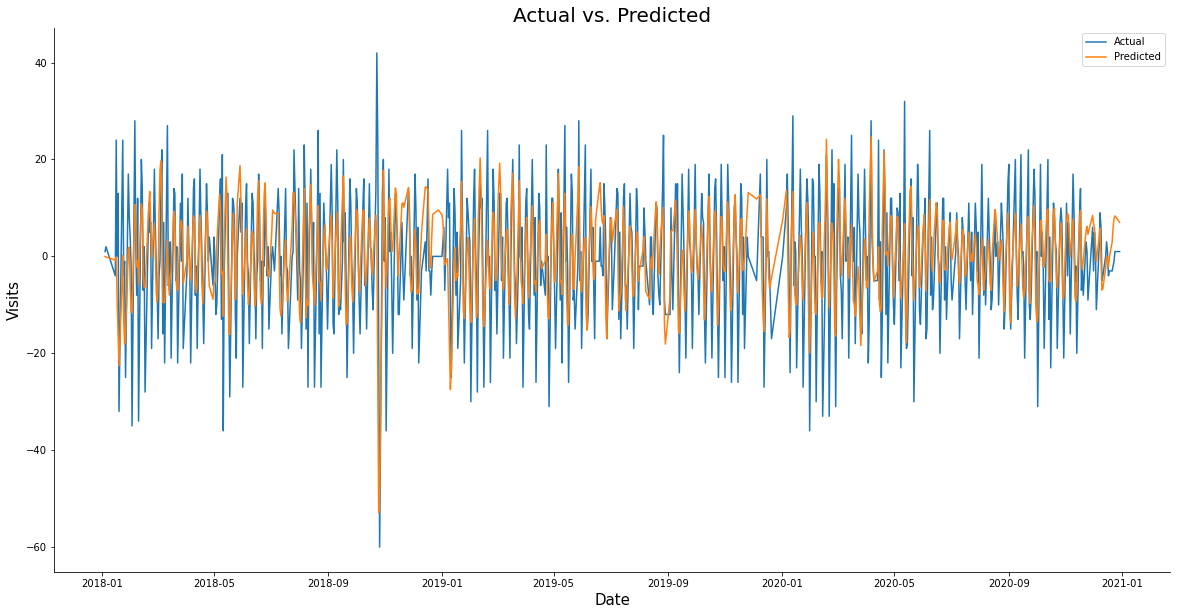

In [71]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(monthly_df_index, order=(2,1,2))
fitted_model = model.fit().predict()

def plot_arima(data, model_predictions):
    
    plt.figure(figsize=(20,10))

    plt.plot(data.diff(), label="Actual", color="tab:blue")
    plt.plot(model_predictions, label="Predicted", color="tab:orange")
    
    ax = plt.gca()
    ax.set_title("Actual vs. Predicted", fontsize = 20)
    ax.set_xlabel("Date", fontsize = 15)
    ax.set_ylabel("Visits", fontsize = 15)
    
    ax.legend()

    sns.despine()
    
plot_arima(monthly_df_index, fitted_model)

### Forecast future visits using Out-of-Time Cross validation

In Out-of-Time cross-validation, you go back in time and forecast into the future to as many steps you took back. After you've done that, you compare the forecast against the actuals.

In [65]:
# Split data into test and training sets 
train_data = monthly_df_index[:525]
test_data  = monthly_df_index[525:]

# Build Model
# model = ARIMA(train, order=(3,2,1))  
model2 = ARIMA(train_data, order=(2, 0, 2))  
fitted_model2 = model2.fit(disp=-1)  

In [66]:
# Print the model results
print(fitted_model2.summary())

                              ARMA Model Results                              
Dep. Variable:              status__c   No. Observations:                  525
Model:                     ARMA(2, 2)   Log Likelihood               -1945.747
Method:                       css-mle   S.D. of innovations              9.837
Date:                Tue, 24 May 2022   AIC                           3903.493
Time:                        12:27:52   BIC                           3929.073
Sample:                             0   HQIC                          3913.510
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              18.7944      0.513     36.669      0.000      17.790      19.799
ar.L1.status__c     0.4862      0.051      9.505      0.000       0.386       0.586
ar.L2.status__c    -0.8215      

In [67]:
# Forecast
fc, se, conf = fitted_model2.forecast(225, alpha=0.05)  # 95% conf

In [68]:
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)

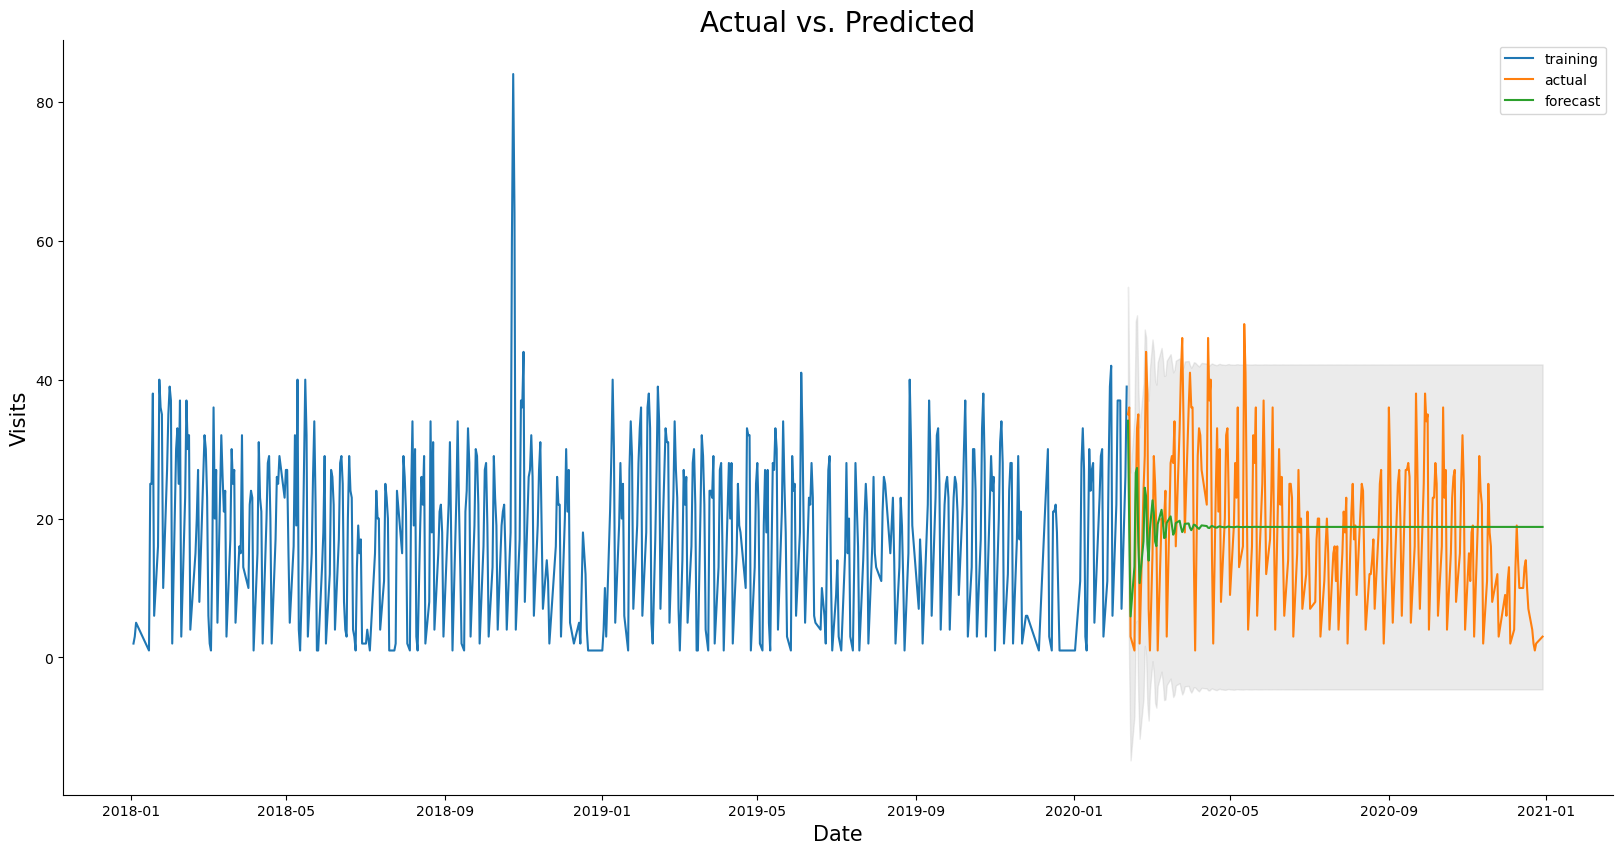

In [69]:
# Plot 
def forecast_arima(test, train):
    
    plt.figure(figsize=(20,10), dpi=100)

    plt.plot(train, label='training', color="tab:blue")
    plt.plot(test, label='actual', color="tab:orange")
    plt.plot(fc_series, label='forecast', color="tab:green")
    
    plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='tab:grey', alpha=.15)
    
    ax = plt.gca()
    ax.set_title("Actual vs. Predicted", fontsize=20)
    ax.set_xlabel("Date", fontsize=15)
    ax.set_ylabel("Visits", fontsize=15)
    ax.legend()

    sns.despine()
    
forecast_arima(test_data, train_data)

### Using accuracy metrics to interpret model performance:

In order to interpret the model performance, we will look at root mean squared error (RMSE) and mean absolute error (MAPE). 
    
   - MAE: Measures how accurate a forecast system is. It measures this accuracy as a percentage, and        can be calculated as the average absolute percent error for each time period minus actual values      divided by actual values.
   - RMSE: Larger RMSE has a greater impact on the overall error while smaller RMSE does not have          as much weight on the overall error.

In [70]:
# Accuracy metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def forecast_accuracy(forecast, actual):
    
    model_scores = {}
    
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    mae = mean_absolute_error(actual, forecast)
    r2 = r2_score(actual, forecast)
    model_scores['ARIMA'] = [rmse, mae, r2]
    
    print("MAPE is", mape)
    print("RMSE is", rmse)
    print("MAE is", mae)
    print("R2 Score is", r2)

forecast_accuracy(fc, test_data.values)

MAPE is 1.4265373321308323
RMSE is 10.874187715925425
MAE is 8.968355103983864
R2 Score is 0.03454731364046437


Our MAPE value tells us that the average difference between the forecasted value and the actual value is 1.43%. Such a small MAPE score tells us that the model is able to forecast values very well.

Our RMSE value tells us that our forecast values were 10.59 values away from the actual.

One thing to take into consideration is that we shouldn't rely too heavily on accuracy measures for forecasting, especially if the pattern being shown by the time series is likely to change in the future. We need to make sure that we have a deep understanding of the business and how changes may impact the forecast. 

## Insights and Recommendations
The purpose of the assignment was to determine whether or not vists drove sales. On top of answering this question, if this was in fact the case, I wanted to go ahead and develop a model to forecast the number of visits. <br>

##### Exploratory Data Analysis:<br>

**Sales:**
- For this analysis, I decided to only use 'AFSaleWM' in the opportunity_data and count of 'status__c' in the visits_data. However, I did use other variables for grouping purposes and joining.
- Total sales over all 3 years is \\$4,437,852, with total sales gradually increasing year over year and with the Johnathon Lovelace Firm accounting for the majority of those sales. 

**Attendees:**
- The total number of attendees over three years was 575,048 and the average per day was 40.48.
- The year with the highest average and total number of attendees was 2020 with 330718 total attendees and an average of 66.45 per day. 

**Visits Count:**
- I used the 'status__c' variable in the visits_data to create a new column called 'visits_count'. This newly created column takes the count of visits grouped by Year, Wholesaler Territory, and FirmName. 
- Based on the newly created column, I'm able to deduce that the total number of visits was greatest in 2018 and dwindled down year over year. 

-Basically, what we are getting from this data is that the number of attendees and sales are increasing year over year. 

##### Correlation Analysis:

- Based off of the EDA and visualizations I created, I can say that visits do have a positive effect on sales; however, to confirm my assumptions, I decided to perform a correlation analysis to determine the relationship between sales and visit count. 
- After running the Spearman's correlation, I got a correlation coefficient of 0.51, which shows a moderate positive relationship. This confirms my assumptions, based on the data that I have been given, that visits drive sales!

##### Forecasting:
- Because I was able to prove the relationship between visits and sales, I attempted to use time series analysis to forecast sales as accurately as possible. 
- The two forecasting methods that I used were:
    1. ARIMA modeling
    2. ARIMA modeling with Out-of-Time Cross Validation
- After performing the forecasting, I wound up with a MAPE score of 1.43. This means that my modeling forecasts fairly accurately.

##### Recommendations:
1. I decided to move forward with the forecasting model because of the moderate correlation between visits and sales; however, I wouldn't be comfortable with using my model in a production environment because the correlation coefficient is ver close to being a low correlation. 
    - I would recommend testing additional variables for correlation or performing proper data transformations to see if we can somehow improve the corr coefficient. 
    - If we can improve on it, then I would be comfortable with implemented a prediction model.
2. Now even though I wouldn't want to pursue modeling in a production environment, the moderate correlation gives enough confidence to believe that the company's marketing strategy is performing well enough to drive up the total number of attendees each year and increase sales. 
3. The business should use time to improve its conversion rate optimization strategy. 
    - More visits are great, but if those visits are not turning into sales then the company is wasting time and money. CG should improve its efforts to scout quality customers with a high likelihood of conversion. 

## Conclusion

- What I learned:<br>
   - I need to use more time researching parameter optimization.
   - Do more research on the problem domain, understanding the theory behind the models that I'm using, and data processing techniques.<br>
<br>
- Whats next?<br>
   - Better understanding of business model will allow me to make better use of the data. 
   - Integrate daily sales data.  Would allow for more granularity and interesting visualizations and predictions. If we treat every quarter and month similarly without taking into account special times of the year, our model loses accuracy. 
   - Implement seasonality into our time series models such as holidays and certain times of the year. 
   - I would have also liked to utilize additional classification models, as I only used one for this assignment. (i.e: Linear Regression, Random Forest, XGBoost, LSTMs).
   - Use the time to perform more elegant data cleansing and transformation.